In [ ]:
%plot inline -w 640

# Nonlinear optimization - 2022.2

## Optimum power for a set of $m$ lamps illuminating a set of $n$ flat patches to best approach a target illumination

Consider $m$ lamps illuminating $n$ (small flat) patches. The illumination intensity $I_k$ at the $k$-th patch depends linearly on the lamp powers $p_j$ as:
$$
I_k = \sum\limits_{j=1}^m a_{k,j}p_j, \quad \text{with} \quad a_{k,j} = r^{-2}_{k,j}\max\{\cos(\theta_{k,j}, 0\},
$$
where $r_{k,j}$ is the length of the vector $\mathbf{r}_{k,j}$ connecting the center of the $k$-th patch to the position of the $m$-th lamp and $\theta_{k,j}$ is the angle between the patch normal vector $\mathbf{n}_{k}$ and $\mathbf{r}_{k,j}$. See the Convex Optimization book slides for more details.

The proposed problem is to achieve a desired illumination $I_{des}$ with bounded lamp powers ($p_{max}$), i.e.,
$$
\begin{align*}
    & \min. \underset{k=1, 2, \ldots, n}{\max}\vert \log(I_k) - \log(I_{des})\vert \\
    \text{s. t.}\quad & 0 \leq p_j \leq p_{max}, j = 1, 2, \ldots, m.
\end{align*}
$$


### Suboptimally solve the problem using, e.g., Matlab, according to the following approaches:

1. Using uniform power, i.e., $p_j = p, 0 \leq p \leq p_{max}$.
2. Using least-squares, i.e., $ \min. \sum\limits_{k=1}^n (I_k - I_{des})^2$, and rounding $p_j$ as $p_j = \max\{0, \min\{p_j, p_{max}\}\}$.
3. Using weighted least-squares, i.e., $ \min. \sum\limits_{k=1}^n (I_k - I_{des})^2 + \sum\limits_{k=1}^n w_j (p_j - p_{max}/2)^2$ and iteratively adjusting the weights $w_j$ until $0 \leq p \leq p_{max}, \forall j$.
4. Using linear programming, i.e., 
$$
\begin{align*}
    & \min. \underset{k=1, 2, \ldots, n}{\max}\vert I_k - I_{des}\vert \\
    \text{s. t.}\quad & 0 \leq p_j \leq p_{max}, j = 1, 2, \ldots, m.
\end{align*}
$$

### Solve the problem optimally using convex optimization

For this goal, consider the equivalent convex problem
$$
\begin{align*}
    & \min. \underset{k=1, 2, \ldots, n}{\max}h(I_k/I_{des}) \\
    \text{s. t.}\quad & 0 \leq p_j \leq p_{max}, j = 1, 2, \ldots, m,
\end{align*}
$$
where $h(u) = \max\{u, 1/u\}$.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import null_space
import cvxpy as cp
import pandas as pd

#Dados ja constantes no problema
showFig = True;
numLamps = 4;
numPatches = 5;
maxPwr = 1;
desiredillum = 0.01;

b = desiredillum*np.ones((numPatches, 1))
#b = np.array([[0.022,0.132,0.015,0.04,0.03]])

lampPos = np.matrix([[0.6838, 7.8976], [3.1835, 7.0690], [5.5327, 6.6806], [6.1963, 6.5203]]).view(complex)
patchPos = np.matrix([[0.0762, 2.8621], [1.4506, 2.8733],[ 2.5122, 2.5864], [4.2246, 3.5846],[ 5.3512, 2.1960], [6.3013, 2.9838]]).view(complex)

pos_center_patch = np.zeros((numPatches, 1), dtype=complex)

for i in range(1, numPatches+1):
    pos_center_patch[i-1].real = 0.5*(patchPos[i-1].real +  patchPos[i].real)
    pos_center_patch[i-1].imag = 0.5*(patchPos[i-1].imag +  patchPos[i].imag)
    
patchNorm = patchPos[1:] - patchPos[0:-1]
minPatchLength = min(np.linalg.norm(patchNorm,axis=1))/2

for p in range(len(patchNorm)):
    n = null_space([[patchNorm[p].real[0,0] , patchNorm[p].imag[0,0]]]);
    patchNorm[p] = minPatchLength*complex(n[0,0],n[1,0])

radDist = np.zeros([len(pos_center_patch), len(lampPos)]);
angShift = np.zeros([len(pos_center_patch), len(lampPos)]);
for i in range(len(pos_center_patch)):
    for j in range(len(lampPos)):
        radDist[i, j] = np.linalg.norm(pos_center_patch[i] - lampPos[j]);
        angShift[i, j] = np.angle(lampPos[j]-pos_center_patch[i])-np.angle(patchNorm[i]);

illumCoeff = radDist**(-2)*np.maximum(np.cos(angShift), 0);

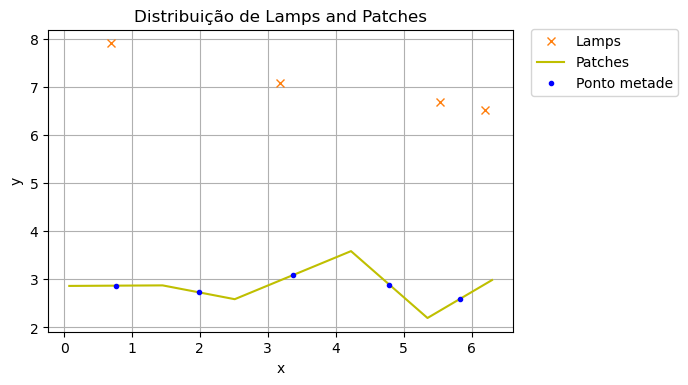

In [2]:
fig0, ax = plt.subplots(figsize=(6, 4), dpi=100)
ax.plot(lampPos.real, lampPos.imag, 'xC1', label='Lamps')
ax.plot(patchPos.real, patchPos.imag, 'y-', label='Patches')
ax.plot(pos_center_patch.real, pos_center_patch.imag, 'b.', label='Ponto metade')
ax.grid()
ax.legend(bbox_to_anchor=(1.37, 1.025))
ax.set_title('Distribuição de Lamps and Patches')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

### Formulações propostas:
O problema consiste em minimizar p para o patch que está recebendo mais luz, com o intuito de  minimizar p para maximizar a iluminação de todos os patches.

In [3]:
# Objective function
def obj_function(power, illumCoeff, b):
    
    if np.isscalar(power):
        # Constroi o vetor para o caso de p constante
        num_lamps = illumCoeff.shape[1]
        vt_p = power*np.ones((num_lamps, 1))
    else:
        vt_p = power
    # illum = {I_k} k = 1, ..., n vetor de tamanho n que corresponde ao iluminação de cada k-patch
    illum = illumCoeff @ vt_p
    # a função retorna a iluminação do patch mais iluminado
    return np.max(np.abs(np.log(illum/b)))


## Formulação 1: Busca Linear
Valor de p constante, identificar qual o valor de p para qual minimiza a função objetivo.

In [4]:
# Configurando a espaço de busca para p
step = 0.00001
array = np.arange(1e-20, 1+step, step)

In [5]:
# Avaliando o valor da função:
f0 = np.array([obj_function(p, illumCoeff, b) for p in array])

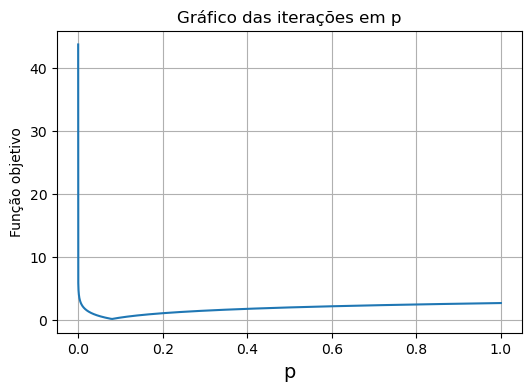

In [6]:
#plotanto a curva caracteristica
fig1, ax = plt.subplots(figsize=(6, 4), dpi=100)
ax.plot(array,f0);
ax.grid()
ax.set_title('Gráfico das iterações em p')
ax.set_xlabel('p',fontsize=14)
ax.set_ylabel('Função objetivo');


In [7]:

p_otimo = array[np.argmin(f0)]
bl_p_otimo = p_otimo * np.ones((4, 1))
bl_valor_otimo = obj_function(bl_p_otimo, illumCoeff, b)
bl_ilummi_otima = illumCoeff @ bl_p_otimo




print('Potencia obtida para cada lampada:')
print(bl_p_otimo.ravel())
print('Função Objetivo ótima: %.4f'%bl_valor_otimo)
print(f'Iluminação alcançada: {bl_ilummi_otima.ravel()}')

Potencia obtida para cada lampada:
[0.07985 0.07985 0.07985 0.07985]
Função Objetivo ótima: 0.1702
Iluminação alcançada: [0.00843522 0.01100453 0.01065768 0.00991766 0.01185474]


## Formulação 2: Least Squares

Formulação dos least squares transforma o problema em:
$$\text{Minimize } \sum_{k=1}^n \boldsymbol||Ap-b|| \\
\text{subject to:}\quad 0\le p\le pmax
$$


In [8]:
#Usando CVXPY para definir e calcular o resultado.
p = cp.Variable([numLamps, 1])
cost_func = cp.sum_squares(illumCoeff @ p - b)
ls_problem = cp.Problem(cp.Minimize(cost_func))
ls_problem.solve()


1.1587713285676025e-06

In [9]:
#rounding 𝑝𝑗 as 𝑝𝑗=max{0,min{𝑝𝑗,𝑝𝑚𝑎𝑥}}
ls_p_otimo = np.maximum(p.value.ravel(),0)
ls_valor_otimo = obj_function(ls_p_otimo, illumCoeff, b)
ls_illum_obtida = illumCoeff @ ls_p_otimo


print('Potencia obtida para cada lampada:')
print(ls_p_otimo.ravel())
print('Função Objetivo ótima: %.4f'%ls_valor_otimo)
print(f'Iluminação alcançada: {ls_illum_obtida.ravel()}')

Potencia obtida para cada lampada:
[0.14080514 0.11888099 0.         0.47087677]
Função Objetivo ótima: 1.0580
Iluminação alcançada: [0.01598076 0.0224947  0.0195139  0.02880654 0.02825822]


## Formulação 3:  Unconstrained weighted least squares
Esse problema se parece com o modelo de pesos da regressão Ridge, portanto será utilizado:</p>
$$ f(p) = ||Ap-b||^2_2 + W||p-p_{max}||^2_2$$

In [10]:
p1 = cp.Variable((numLamps, 1))
lambd = cp.Parameter(shape=(numLamps,1), nonneg=True,
                        value=0*np.ones((numLamps, 1)))
Ap = np.matmul(illumCoeff , p1)
problem = cp.Problem(cp.Minimize(cp.sum_squares(illumCoeff @ p1 - b) + lambd.T@(p1-0.5*maxPwr)**2))

problem.solve()

for i in range(10000):
    p_le_z = (p1.value <=0)
    p_ge_maxpwr = (p1.value >=maxPwr)
    for j in range(4):
        if p_le_z[j] == True:
            lambd.value[j] *= 1.01
            if lambd.value[j]==0: lambd.value[j]+=0.000001 
        if p_ge_maxpwr[j] == True:
            lambd.value[j] /= 1.01
    problem.solve()

wls_p_otimo = p1.value.ravel()
wls_valor_otimo = obj_function(wls_p_otimo, illumCoeff, b)
wls_illum_obtida = illumCoeff @ wls_p_otimo

In [11]:
print('Potencia obtida para cada lampada:')
print(wls_p_otimo.ravel())
print('Função Objetivo ótima: %.4f'%wls_valor_otimo)
print(f'Iluminação alcançada: {wls_illum_obtida.ravel()}')

Potencia obtida para cada lampada:
[0.19075494 0.00489872 0.00139609 0.15991685]
Função Objetivo ótima: 0.0934
Iluminação alcançada: [0.00979705 0.01032809 0.00939468 0.0093064  0.01097866]


## Formulação 4: linear programming:
O problema consiste em linearizar a função da seguinte forma:
$$
\begin{align*}
    & \min. \underset{k=1, 2, \ldots, n}{\max}\vert I_k - I_{des}\vert \\
    \text{s. t.}\quad & 0 \leq p_j \leq p_{max}, j = 1, 2, \ldots, m.
\end{align*}
$$
Sabemos que a função norm_inf é exatamente o que é pedido na formulação, portanto, o problema quando modelado se torna:

In [23]:
p = cp.Variable((numLamps, 1))
cost_func = cp.norm_inf(illumCoeff @ p - b)
lp_problem = cp.Problem(cp.Minimize(cost_func), [p >= 0, p <= maxPwr ])
lp_problem.solve()
lp_p_otimo = p.value
lp_valor_otimo = obj_function(lp_p_otimo, illumCoeff, b)

lp_ilummi_otima = illumCoeff @ lp_p_otimo

In [13]:

print('Potencia obtida para cada lampada:')
print(lp_p_otimo.ravel())
print('Função Objetivo ótima: %.4f'%lp_valor_otimo)
print(f'Iluminação alcançada: {lp_ilummi_otima.ravel()}')

Potencia obtida para cada lampada:
[1.65128266e-01 1.89139029e-02 1.32091372e-08 1.55957722e-01]
Função Objetivo ótima: 0.0008
Iluminação alcançada: [0.00922453 0.01008397 0.00922453 0.00922453 0.01077547]


## Formulação convexa:
Utilizando a proposição feita pelo enunciado, temos o seguinte problema:
$$
\begin{align*}
    & \min. \underset{k=1, 2, \ldots, n}{\max}h(I_k/I_{des}) \\
    \text{s. t.}\quad & 0 \leq p_j \leq p_{max}, j = 1, 2, \ldots, m,
\end{align*}
$$
aonde $h(u) = \max\{u, 1/u\}$.</p>
Portanto sua formulação codificada seria:

In [21]:
#Definindo h(u), sabemos que h(u) é convexa pois o maximo de duas funções convexas é convexo
def h(u):
    return cp.maximum(u, cp.inv_pos(u))

p = cp.Variable((numLamps, 1))
func = cp.max(h(illumCoeff @ p / b))
problem = cp.Problem(cp.Minimize(func), [p >= 0, p <= maxPwr])

problem.solve()



cv_p_otimo = p.value
cv_valor_otimo = obj_function(cv_p_otimo, illumCoeff, b)
cv_ilummi_otima = illumCoeff @ cv_p_otimo

In [22]:
print('Potencia obtida para cada lampada:')
print(cv_p_otimo.ravel())
print('Função Objetivo ótima: %.4f'%cv_valor_otimo)
print(f'Iluminação alcançada: {cv_ilummi_otima.ravel()}')

Potencia obtida para cada lampada:
[1.65627010e-01 1.89710343e-02 1.70719382e-10 1.56428783e-01]
Função Objetivo ótima: 0.0777
Iluminação alcançada: [0.0092524  0.01011443 0.0092524  0.0092524  0.01080801]


### Resultados:
Reunindo todos os vetores de configurações de p podemos avaliar cada proposta:

In [24]:
#Vetores de solução:
p_lamps = np.array([bl_p_otimo.ravel(), ls_p_otimo, wls_p_otimo, lp_p_otimo.ravel(), cv_p_otimo.ravel()])

#Valores ótimos:
v_otimo = [bl_valor_otimo, ls_valor_otimo, wls_valor_otimo, lp_valor_otimo, cv_valor_otimo]

#iluminações otimas:
illums = np.array([bl_ilummi_otima.ravel(), ls_illum_obtida, wls_illum_obtida, lp_ilummi_otima.ravel(), cv_ilummi_otima.ravel()])

In [25]:
optima = pd.DataFrame(p_lamps, 
             index=['Busca Linear', 'Least Squares', 'Weighted LS', 'Linear Program','Convex'],
             columns=[f'$p^*_{i+1}$' for i in range(numLamps)])

results = pd.DataFrame(illums, 
             index=['Busca Linear', 'Least Squares', 'Weighted LS', 'Linear Program','Convex'],
             columns=[f'$I_{i+1}$' for i in range(numPatches)])
results.insert(numPatches, '$f_{0}(p^*)$', v_otimo)

In [27]:
print('\nValores otimos para a potencia das lampadas:')
display(optima)
print('Iluminação otima para todas as formulações:')
display(results)


Valores otimos para a potencia das lampadas:


,$p^*_1$,$p^*_2$,$p^*_3$,$p^*_4$
Busca Linear,0.079850,0.079850,7.985000e-02,0.079850
Least Squares,0.140805,0.118881,0.000000e+00,0.470877
Weighted LS,0.190755,0.004899,1.396093e-03,0.159917
Linear Program,0.165128,0.018914,1.320914e-08,0.155958
Convex,0.165627,0.018971,1.707194e-10,0.156429


Iluminação otima para todas as formulações:


,$I_1$,$I_2$,$I_3$,$I_4$,$I_5$,$f_{0}(p^*)$
Busca Linear,0.008435,0.011005,0.010658,0.009918,0.011855,0.170169
Least Squares,0.015981,0.022495,0.019514,0.028807,0.028258,1.058017
Weighted LS,0.009797,0.010328,0.009395,0.009306,0.010979,0.093368
Linear Program,0.009225,0.010084,0.009225,0.009225,0.010775,0.080718
Convex,0.009252,0.010114,0.009252,0.009252,0.010808,0.077703
